In [ ]:
pip install keras-tuner

In [2]:
import mlflow
import mlflow.keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from kerastuner import HyperModel, RandomSearch
import os
from kerastuner import HyperParameters
# Установите URI для отслеживания MLflow
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('batch_size')

C:\Users\User\AppData\Local\Temp\ipykernel_22152\3632682749.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


<Experiment: artifact_location='mlflow-artifacts:/829106281553639360', creation_time=1743618073299, experiment_id='829106281553639360', last_update_time=1743618073299, lifecycle_stage='active', name='batch_size', tags={}>

In [3]:
classes = os.listdir('augmented')

# simple (not work)

In [ ]:
# Определите вашу модель CNN
def create_model(filters_1=32, filters_2=64, filters_3=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters_1, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))  # Предполагается 10 классов
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [5]:
import matplotlib.pyplot as plt

In [71]:
# Функция для обучения модели и логирования в MLflow
def train_model(filters_1=32, filters_2=64, filters_3=128,
                dropout_rate=0.5, learning_rate=0.001,
                batch_size=32, epochs=10):
    
    with mlflow.start_run():
        # Создание модели с заданными гиперпараметрами
        model = create_model(filters_1=filters_1,
                             filters_2=filters_2,
                             filters_3=filters_3,
                             dropout_rate=dropout_rate,
                             learning_rate=learning_rate)
        
        # Подготовка данных из папки augmented
        datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 
        
        train_generator = datagen.flow_from_directory(
            'augmented',
            target_size=(100, 100),
            batch_size=batch_size,
            shuffle = True,
            class_mode='categorical',
            subset='training'
        )
        
        validation_generator = datagen.flow_from_directory(
            'augmented',
            target_size=(100, 100),
            batch_size=batch_size,
            shuffle = True,
            class_mode='categorical',
            subset='validation'
        )
        
        # Обучение модели с логированием в MLflow и метрик после каждой эпохи
        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            epochs=epochs) 
        
        # Логирование модели в MLflow
        mlflow.keras.log_model(model, "model")

        # Логирование гиперпараметров после завершения обучения
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("filters_1", filters_1)
        mlflow.log_param("filters_2", filters_2)
        mlflow.log_param("filters_3", filters_3)
        mlflow.log_param("dropout_rate", dropout_rate)
        mlflow.log_param("learning_rate", learning_rate)

        for epoch in range(len(history.history['val_accuracy'])):
            mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
            mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)  # Сохраняем val_loss
            mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)  # Сохраняем loss

        # Создание графика для accuracy
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')

        # Сохранение графика accuracy как изображения
        accuracy_plot_file_path = "accuracy_plot.png"
        plt.savefig(accuracy_plot_file_path)
        
        # Закрытие графика
        plt.close()

        # Логирование изображения accuracy в MLflow
        mlflow.log_artifact(accuracy_plot_file_path)

        
        # Создание графика для loss
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper left')

        # Сохранение графика loss как изображения
        loss_plot_file_path = "loss_plot.png"
        plt.savefig(loss_plot_file_path)
        
        # Закрытие графика
        plt.close()

         # Логирование изображения loss в MLflow
        mlflow.log_artifact(loss_plot_file_path)

In [ ]:
import itertools
# Списки параметров для перебора
filters_1_list = [16, 32]
filters_2_list = [32, 64]
filters_3_list = [64, 128]
dropout_rates = [0.5]
learning_rate = [0.001, 0.0001]
batch_sizes = [32, 64]
epochs_list = [5]

# Генерация всех возможных комбинаций параметров
param_combinations = itertools.product(filters_1_list,
                                        filters_2_list,
                                        filters_3_list,
                                        dropout_rates,
                                        learning_rate,
                                        batch_sizes,
                                        epochs_list)

# Обучение модели для каждой комбинации параметров
for params in param_combinations:
    filters_1, filters_2, filters_3, dropout_rate, learning_rate, batch_size, epochs = params
    
    print(f"Обучение модели с параметрами: "
          f"filters_1={filters_1}, "
          f"filters_2={filters_2}, "
          f"filters_3={filters_3}, "
          f"dropout_rate={dropout_rate}, "
          f"learning_rate={learning_rate},"
          f"batch_size={batch_size}, "
          f"epochs={epochs}")
    
    train_model(filters_1=filters_1,
                filters_2=filters_2,
                filters_3=filters_3,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate,
                batch_size=batch_size,
                epochs=epochs)

print("Обучение завершено.")

# Без ImageGenerator(work)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
def create_model(dropout_rate=0.5, im_shape=(100, 100, 3), learning_rate=0.001):
    cnn_model = Sequential([
        # Первый сверточный слой
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=im_shape),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),  # Слой нормализации
        Dropout(dropout_rate),          # Слой дропаут

        # Второй сверточный слой
        # Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        # MaxPooling2D(pool_size=(2, 2)),
        # BatchNormalization(),  # Слой нормализации
        # Dropout(dropout_rate),          # Слой дропаут

        Flatten(),             # Преобразование в одномерный вектор

        # Полносвязный слой
        Dense(1024, activation='relu'),

        # Выходной слой для классификации на 43 класса
        Dense(len(classes), activation='softmax')  
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model(dropout_rate=0.5, im_shape=(100, 100, 3), learning_rate=0.001):
    cnn_model = Sequential([
        Conv2D(filters=36, kernel_size=7, activation='relu', input_shape=im_shape),
        MaxPooling2D(pool_size=2),
        Conv2D(filters=54, kernel_size=5, activation='relu'),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(2024, activation='relu'),
        Dropout(dropout_rate),
        Dense(1024, activation='relu'),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(classes), activation='softmax')  # Предполагается 20 классов
    ])
    optimizer = Adam(learning_rate=learning_rate)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

In [12]:
len(classes)

31

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# Определите вашу модель CNN
def create_model(filters_1=32, filters_2=64, filters_3=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters_1, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))  # Предполагается 10 классов
    
    optimazer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimazer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [4]:
from PIL import Image
import numpy as np

def load_image(file_path, target_size=(100, 100)):
    """
    Загружает изображение из указанного пути, изменяет его размер и нормализует пиксели.

    :param file_path: Путь к файлу изображения.
    :param target_size: Размер, до которого нужно изменить изображение (ширина, высота).
    :return: Нормализованное изображение в виде массива NumPy.
    """
    # Открываем изображение
    image = Image.open(file_path)

    # Изменяем размер изображения
    image = image.resize(target_size)

    # Преобразуем изображение в массив NumPy
    image_array = np.array(image)

    # Нормализация пикселей (если необходимо)
    # Приводим значения пикселей к диапазону [0, 1]
    image_array = image_array / 255.0

    return image_array

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_model(X_train, X_test, y_train, y_test,
                dropout_rate=0.3, learning_rate=0.0001,
                batch_size=32, epochs=10):
    
    with mlflow.start_run():
        # Создание модели с заданными гиперпараметрами
        model = create_model(dropout_rate=dropout_rate,
                             learning_rate=learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss',  # Можно использовать 'val_accuracy' для мониторинга точности
                               patience=2,         # Количество эпох без улучшения перед остановкой
                               restore_best_weights=True)  # Восстановить лучшие веса
        reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Метрика для мониторинга
                               factor=0.5,          # На сколько уменьшать learning rate
                               patience=2,         # Количество эпох без улучшения перед уменьшением
                               min_lr=1e-6)        # Минимально допустимый learning rate
        
        # Обучение модели с логированием в MLflow и метрик после каждой эпохи
        history = model.fit(X_train,
                            y_train,
                            validation_data=(X_test, y_test),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping, reduce_lr])
        
        # Логирование модели в MLflow
        mlflow.keras.log_model(model, "model")

        # Логирование гиперпараметров после завершения обучения
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("dropout_rate", dropout_rate)
        mlflow.log_param("learning_rate", learning_rate)
  
        for epoch in range(len(history.history['val_accuracy'])):
            mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
            mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)  
            mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)  

        # Создание графика для accuracy
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')

        # Сохранение графика accuracy как изображения
        accuracy_plot_file_path = "accuracy_plot.png"
        plt.savefig(accuracy_plot_file_path)
        
        # Закрытие графика
        plt.close()

        # Логирование изображения accuracy в MLflow
        mlflow.log_artifact(accuracy_plot_file_path)

    
        # Создание графика для loss
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper left')

        # Сохранение графика loss как изображения
        loss_plot_file_path = "loss_plot.png"
        plt.savefig(loss_plot_file_path)

        # Закрытие графика 
        plt.close()

        # Логирование изображения loss в MLflow 
        mlflow.log_artifact(loss_plot_file_path)

In [30]:
del X
del y

In [17]:
X = []
y = []
data_dir = 'augmented'
for person_folder in os.listdir(data_dir):
    person_path = os.path.join(data_dir, person_folder)
    if os.path.isdir(person_path):  # Проверяем, что это папка
        for file_name in os.listdir(person_path):
            file_path = os.path.join(person_path, file_name)
            if file_name.endswith('.jpg') or file_name.endswith('.png'):  # Замените на нужные форматы
                # Здесь вы можете загрузить изображение или данные
                image = load_image(file_path)  # Замените на вашу функцию загрузки изображения
                X.append(image)
                y.append(person_folder)

X = np.array(X)
y = np.array(y)

In [18]:
len(X)

12400

In [ ]:
del y_one_hot, X_train, X_test, y_train, y_test

In [20]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # sparse=False для получения массива NumPy вместо разреженной матрицы
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))  # Преобразуем y в двумерный массив

print("Размер X:", X.shape)
print("Размер y (one-hot):", y_one_hot.shape)

Размер X: (12400, 100, 100, 3)
Размер y (one-hot): (12400, 31)


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

print("Размер обучающей выборки X:", X_train.shape)
print("Размер тестовой выборки X:", X_test.shape)
print("Размер обучающей выборки y:", y_train.shape)
print("Размер тестовой выборки y:", y_test.shape)

Размер обучающей выборки X: (9920, 100, 100, 3)
Размер тестовой выборки X: (2480, 100, 100, 3)
Размер обучающей выборки y: (9920, 31)
Размер тестовой выборки y: (2480, 31)


In [ ]:
import itertools

dropout_rates = [0.4, 0.3]
learning_rate = [0.0001]
batch_sizes = [32, 64]
epochs_list = [10]

# Генерация всех возможных комбинаций параметров
param_combinations = itertools.product(dropout_rates,
                                        learning_rate,
                                        batch_sizes,
                                        epochs_list)

# Обучение модели для каждой комбинации параметров
for params in param_combinations:
    dropout_rate, learning_rate, batch_size, epochs = params
    
    print(f"Обучение модели с параметрами: "
          f"dropout_rate={dropout_rate}, "
          f"learning_rate={learning_rate},"
          f"batch_size={batch_size}, "
          f"epochs={epochs}")
    
    train_model(X_train, X_test, y_train, y_test,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate,
                batch_size=batch_size,
                epochs=epochs)

print("Обучение завершено.")

# Batch

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# Определите вашу модель CNN
def create_model(filters_1=32, filters_2=64, filters_3=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters_1, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))  # Предполагается 10 классов
    
    optimazer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimazer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [67]:
import mlflow
import mlflow.keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from kerastuner import HyperModel, RandomSearch
import os

In [68]:
del X, y

In [69]:
X = []
y = []
data_dir = 'augmented'
for person_folder in os.listdir(data_dir):
    person_path = os.path.join(data_dir, person_folder)
    if os.path.isdir(person_path):  # Проверяем, что это папка
        for file_name in os.listdir(person_path):
            file_path = os.path.join(person_path, file_name)
            if file_name.endswith('.jpg') or file_name.endswith('.png'):  # Замените на нужные форматы
                # Здесь вы можете загрузить изображение или данные
                image = load_image(file_path)  # Замените на вашу функцию загрузки изображения
                X.append(image)
                y.append(person_folder)

X = np.array(X)
y = np.array(y)

In [70]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # sparse=False для получения массива NumPy вместо разреженной матрицы
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))  # Преобразуем y в двумерный массив

print("Размер X:", X.shape)
print("Размер y (one-hot):", y_one_hot.shape)

Размер X: (18600, 100, 100, 3)
Размер y (one-hot): (18600, 31)


In [71]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
from sklearn.model_selection import train_test_split

# Сначала выделяем test
X_temp, X_test, y_temp, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

# Затем делим оставшиеся данные на train и val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
# 0.25 от оставшихся 80% = 20% → итого 60% train / 20% val / 20% test
print("Размер обучающей выборки X:", X_train.shape)
print("Размер тестовой выборки X:", X_test.shape)
print("Размер обучающей выборки y:", y_train.shape)
print("Размер тестовой выборки y:", y_test.shape)

Размер обучающей выборки X: (11160, 100, 100, 3)
Размер тестовой выборки X: (3720, 100, 100, 3)
Размер обучающей выборки y: (11160, 31)
Размер тестовой выборки y: (3720, 31)


In [ ]:
import mlflow 
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

def train_model(X_train, X_test, y_train, y_test, 
                learning_rate=0.0001, dropout_rate=0.3, 
                batch_sizes=[8, 16, 32, 64, 128], epochs=10):
    
    accuracies = []  # Список для хранения значений точности
    
    for batch_size in batch_sizes:
        with mlflow.start_run():
            model = create_model(dropout_rate=dropout_rate, learning_rate=learning_rate)
            
            # early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
            
            history = model.fit(X_train, y_train,
                                validation_data=(X_test, y_test),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[reduce_lr])
            
            mlflow.keras.log_model(model, "model")
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("dropout_rate", dropout_rate)
            mlflow.log_param("learning_rate", learning_rate)
            
            final_accuracy = max(history.history['val_accuracy'])  # Максимальное значение val_accuracy
            accuracies.append((batch_size, final_accuracy))
            
            for epoch in range(len(history.history['val_accuracy'])):
                mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
                mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
                mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
    
    # Создание итогового графика точности
    batch_sizes, accuracy_values = zip(*accuracies)
    indices = np.arange(len(batch_sizes))  # Равномерные индексы по X
    
    # Определяем границы графика
    y_min = min(accuracy_values) - 0.02  # Чуть ниже минимального значения
    y_max = max(accuracy_values) + 0.02  # Чуть выше максимального значения

    plt.figure(figsize=(6, 4))
    plt.plot(indices, accuracy_values, marker='o', linestyle='-', color='b')

    # Улучшаем отображение меток
    for i, txt in enumerate(accuracy_values):
        offset = 0.02  # Базовое смещение
        
        # Проверяем соседние значения и увеличиваем отступ при необходимости
        if i > 0 and abs(accuracy_values[i] - accuracy_values[i - 1]) < 0.02:
            offset += 0.01
        if i < len(accuracy_values) - 1 and abs(accuracy_values[i] - accuracy_values[i + 1]) < 0.02:
            offset += 0.01

        plt.text(indices[i], accuracy_values[i] + offset, f'{txt:.3f}', 
                fontsize=9, color='blue', ha='center')
        plt.plot([indices[i], indices[i]], [accuracy_values[i], y_text], 
            linestyle='dashed', color='gray', linewidth=0.8)

    # Настроим оси и подписи
    plt.xlabel("Batch size")
    plt.ylabel("Accuracy")
    plt.ylim(y_min, y_max)
    plt.title("Accuracy vs. Batch Size")
    plt.xticks(indices, batch_sizes)  # Устанавливаем равномерные метки на X
    
    accuracy_plot_file_path = "accuracy_vs_batchsize.png"
    plt.savefig(accuracy_plot_file_path)
    plt.close()
    
    # Логирование графика через MLflow
    mlflow.log_artifact(accuracy_plot_file_path)

In [ ]:
train_model(X_train, X_test, y_train, y_test)

# lr

In [11]:
import mlflow 
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

def train_model(X_train, X_test, y_train, y_test, 
                learning_rates=[0.00001, 0.0001, 0.001], dropout_rate=0.3, 
                batch_size=8, epochs=10):
    
    accuracies = []  # Список для хранения значений точности
    
    for learning_rate in learning_rates:
        with mlflow.start_run():
            # Создаем модель с текущими параметрами
            model = create_model(dropout_rate=dropout_rate, learning_rate=learning_rate)
            
            # Настройка для динамического уменьшения learning rate
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
            
            # Обучаем модель
            history = model.fit(X_train, y_train,
                                validation_data=(X_test, y_test),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[reduce_lr])
            
            # Логирование модели в MLflow
            mlflow.keras.log_model(model, "model")
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("dropout_rate", dropout_rate)
            mlflow.log_param("learning_rate", learning_rate)
            
            # Записываем максимальную точность в список
            final_accuracy = max(history.history['val_accuracy'])  # Максимальное значение val_accuracy
            accuracies.append((learning_rate, final_accuracy))
            
            # Логирование метрик для каждой эпохи
            for epoch in range(len(history.history['val_accuracy'])):
                mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
                mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
                mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
    
    # Создание итогового графика точности
    learning_rates, accuracy_values = zip(*accuracies)
    indices = np.arange(len(learning_rates))  # Равномерные индексы по X
    
    # Определяем границы графика
    y_min = min(accuracy_values) - 0.02  # Чуть ниже минимального значения
    y_max = max(accuracy_values) + 0.02  # Чуть выше максимального значения

    plt.figure(figsize=(6, 4))
    plt.plot(indices, accuracy_values, marker='o', linestyle='-', color='b')

    # Размещаем подписи для значений
    for i, txt in enumerate(accuracy_values):
        offset = 0.02  # Базовое смещение
        
        # Проверяем соседние значения и увеличиваем отступ при необходимости
        if i > 0 and abs(accuracy_values[i] - accuracy_values[i - 1]) < 0.02:
            offset += 0.01
        if i < len(accuracy_values) - 1 and abs(accuracy_values[i] - accuracy_values[i + 1]) < 0.02:
            offset += 0.01
        
        # Добавляем подпись
        plt.text(indices[i], accuracy_values[i] + offset, f'{txt:.3f}', 
                 fontsize=9, color='blue', ha='center')
        plt.plot([indices[i], indices[i]], [accuracy_values[i], y_max], 
                 linestyle='dashed', color='gray', linewidth=0.8)

    # Настройка осей и подписи
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.ylim(y_min, y_max)
    plt.title("Accuracy vs. Learning Rate")
    plt.xticks(indices, learning_rates)  # Устанавливаем равномерные метки на X
    
    # Сохраняем и логируем график через MLflow
    accuracy_plot_file_path = "accuracy_vs_learning_rate.png"
    plt.savefig(accuracy_plot_file_path)
    plt.close()
    
    # Логирование графика в MLflow
    mlflow.log_artifact(accuracy_plot_file_path)

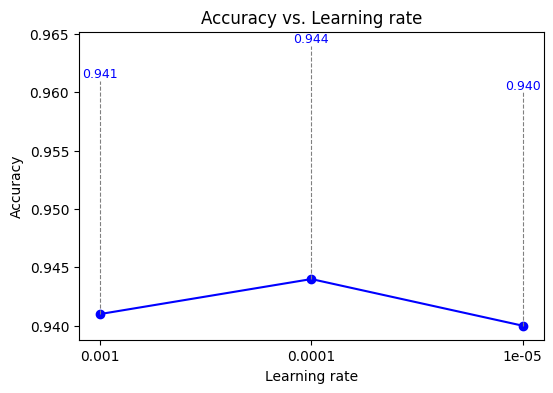

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Задаем возможные значения batch size
batch_sizes = [0.001, 0.0001, 0.00001]

# Указываем значения точности для каждого размера batch size
accuracy_values = [0.941, 0.944, 0.940]

# Создаем равномерные индексы для оси X
indices = np.arange(len(batch_sizes))

# Определяем границы графика
y_min = min(accuracy_values) - 0.02  # Чуть ниже минимального значения
y_max = max(accuracy_values) + 0.02  # Чуть выше максимального значения

# Строим график
plt.figure(figsize=(6, 4))
plt.plot(indices, accuracy_values, marker='o', linestyle='-', color='b')

# Размещаем подписи и пунктирные линии
for i, txt in enumerate(accuracy_values):
    if accuracy_values[i] - y_min < 0.03:  
        y_text = accuracy_values[i] + 0.02  # Если точка близко к низу графика — подпись сверху
        va_align = 'bottom'
    else:
        y_text = accuracy_values[i] - 0.02  # Иначе подпись снизу
        va_align = 'top'
    
    # Добавляем подпись
    plt.text(indices[i], y_text, f'{txt:.3f}', 
             fontsize=9, color='blue', ha='center', va=va_align)
    
    # Добавляем пунктирную линию от точки к подписи
    plt.plot([indices[i], indices[i]], [accuracy_values[i], y_text], 
             linestyle='dashed', color='gray', linewidth=0.8)

# Подписываем оси и заголовок
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning rate")

# Устанавливаем метки на оси X (параметры batch size)
plt.xticks(indices, batch_sizes)

# Показываем график
plt.show()

In [19]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('learning_rate')

<Experiment: artifact_location='mlflow-artifacts:/368895139486111308', creation_time=1743629689482, experiment_id='368895139486111308', last_update_time=1743629689482, lifecycle_stage='active', name='learning_rate', tags={}>

In [20]:
train_model(X_train, X_test, y_train, y_test)

c:\Users\User\anaconda3\envs\cv_project\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 92s 72ms/step - accuracy: 0.1490 - loss: 3.3723 - val_accuracy: 0.4589 - val_loss: 1.9544 - learning_rate: 1.0000e-05
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - accuracy: 0.4786 - loss: 1.8326 - val_accuracy: 0.5915 - val_loss: 1.4764 - learning_rate: 1.0000e-05
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.6361 - loss: 1.2764 - val_accuracy: 0.6742 - val_loss: 1.1971 - learning_rate: 1.0000e-05
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.7439 - loss: 0.9307 - val_accuracy: 0.7302 - val_loss: 1.0139 - learning_rate: 1.0000e-05
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 71ms/step - accuracy: 0.8072 - loss: 0.7100 - val_accuracy: 0.7714 - val_loss: 0.8859 - learning_rate: 1.0000e-05
Epoch 6/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.8676 - loss: 0.5243 - val_accuracy: 0.7944 - val_loss: 0.7960 - learning_rate: 1.0000e-05
Epoch 7/10
1240/1240 ━━━━━━━━━━━━━━━━━━

2025/04/03 01:01:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 01:01:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run spiffy-owl-842 at: http://127.0.0.1:5000/#/experiments/368895139486111308/runs/bdc9171b76824b5cb5a84869e8f1e940
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/368895139486111308
Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 93s 73ms/step - accuracy: 0.3227 - loss: 2.6881 - val_accuracy: 0.6754 - val_loss: 1.1083 - learning_rate: 1.0000e-04
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.8033 - loss: 0.6602 - val_accuracy: 0.7867 - val_loss: 0.7394 - learning_rate: 1.0000e-04
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 89s 72ms/step - accuracy: 0.9370 - loss: 0.2252 - val_accuracy: 0.8258 - val_loss: 0.6428 - learning_rate: 1.0000e-04
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.9680 - loss: 0.1210 - val_accuracy: 0.8286 - val_loss: 0.6118 - learning_rate: 1.0000e-04
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.9771 - loss: 0.0839 - val_accuracy: 0.8254 - val_loss: 0.6757 - learning_rate: 1.0000e-04


2025/04/03 01:16:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 01:16:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run legendary-midge-921 at: http://127.0.0.1:5000/#/experiments/368895139486111308/runs/d06f7fde332f4347a9f20a3c20a28f60
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/368895139486111308
Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 92s 73ms/step - accuracy: 0.2959 - loss: 3.1008 - val_accuracy: 0.4185 - val_loss: 3.2111 - learning_rate: 0.0010
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 89s 72ms/step - accuracy: 0.7076 - loss: 0.9942 - val_accuracy: 0.6629 - val_loss: 1.1428 - learning_rate: 0.0010
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.8287 - loss: 0.5640 - val_accuracy: 0.6907 - val_loss: 1.2001 - learning_rate: 0.0010
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.8904 - loss: 0.3551 - val_accuracy: 0.6242 - val_loss: 1.3574 - learning_rate: 0.0010
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - accuracy: 0.9496 - loss: 0.1551 - val_accuracy: 0.8730 - val_loss: 0.5311 - learning_rate: 5.0000e-04
Epoch 6/10

2025/04/03 01:33:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 01:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run useful-turtle-521 at: http://127.0.0.1:5000/#/experiments/368895139486111308/runs/b2e3d991984d4065835ee35fab7f50eb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/368895139486111308


In [44]:
mlflow.end_run()

🏃 View run dashing-conch-532 at: http://127.0.0.1:5000/#/experiments/829106281553639360/runs/06d3b0b5668642caba4718eb1a8e730e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829106281553639360


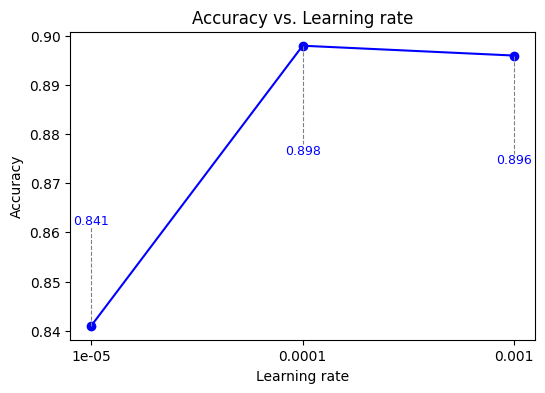

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Задаем возможные значения batch size
batch_sizes = [0.00001, 0.0001, 0.001]

# Указываем значения точности для каждого размера batch size
accuracy_values = [0.841, 0.898, 0.896]

# Создаем равномерные индексы для оси X
indices = np.arange(len(batch_sizes))

# Определяем границы графика
y_min = min(accuracy_values) - 0.02  # Чуть ниже минимального значения
y_max = max(accuracy_values) + 0.02  # Чуть выше максимального значения

# Строим график
plt.figure(figsize=(6, 4))
plt.plot(indices, accuracy_values, marker='o', linestyle='-', color='b')

# Размещаем подписи и пунктирные линии
for i, txt in enumerate(accuracy_values):
    if accuracy_values[i] - y_min < 0.03:  
        y_text = accuracy_values[i] + 0.02  # Если точка близко к низу графика — подпись сверху
        va_align = 'bottom'
    else:
        y_text = accuracy_values[i] - 0.02  # Иначе подпись снизу
        va_align = 'top'
    
    # Добавляем подпись
    plt.text(indices[i], y_text, f'{txt:.3f}', 
             fontsize=9, color='blue', ha='center', va=va_align)
    
    # Добавляем пунктирную линию от точки к подписи
    plt.plot([indices[i], indices[i]], [accuracy_values[i], y_text], 
             linestyle='dashed', color='gray', linewidth=0.8)

# Подписываем оси и заголовок
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning rate")

# Устанавливаем метки на оси X (параметры batch size)
plt.xticks(indices, batch_sizes)

# Показываем график
plt.show()

# Smoothing

In [30]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('with_smoothing')

<Experiment: artifact_location='mlflow-artifacts:/584124971497788721', creation_time=1743633952876, experiment_id='584124971497788721', last_update_time=1743633952876, lifecycle_stage='active', name='with_smoothing', tags={}>

In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K

def categorical_crossentropy_with_smoothing(y_true, y_pred, smoothing_factor=0.1):
    # Сглаживаем метки
    num_classes = K.cast(K.shape(y_true)[-1], K.floatx())
    y_true_smooth = (1 - smoothing_factor) * y_true + smoothing_factor / num_classes
    
    # Классическая кросс-энтропия
    loss = K.categorical_crossentropy(y_true_smooth, y_pred)
    return loss


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf

# Определите вашу модель CNN
def create_model(filters_1=32, filters_2=64, filters_3=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters_1, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters_2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))  # Предполагается 10 классов
    
    optimazer = Adam(learning_rate=learning_rate)
    
    # Используем нашу кастомную функцию потерь
    model.compile(optimizer=optimazer, loss=categorical_crossentropy_with_smoothing, metrics=['accuracy'])
    
    return model

In [32]:
def train_model(X_train, X_test, y_train, y_test, learning_rate=0.0001, dropout_rate=0.3, batch_size=8, epochs=10):
    with mlflow.start_run():
        # Логируем параметры
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("dropout_rate", dropout_rate)
        mlflow.log_param("batch_size", batch_size)
        
        # Создаем и тренируем модель
        model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

        # Логируем метрики
        mlflow.log_metric("train_accuracy", max(history.history['accuracy']))
        mlflow.log_metric("val_accuracy", max(history.history['val_accuracy']))
        mlflow.log_metric("train_loss", min(history.history['loss']))
        mlflow.log_metric("val_loss", min(history.history['val_loss']))
        
        # Логируем модель
        mlflow.keras.log_model(model, "model")

        # Логируем график точности (если нужно)
        accuracy_plot_file_path = "accuracy_vs_smoothing.png"
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['accuracy'], label="Train Accuracy")
        plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy vs Epochs (LR={learning_rate})")
        plt.legend()
        plt.savefig(accuracy_plot_file_path)
        plt.close()

        # Логируем график
        mlflow.log_artifact(accuracy_plot_file_path)

# Пример использования
# Замените X_train, X_test, y_train, y_test на ваши данные
train_model(X_train, X_test, y_train, y_test, learning_rate=0.0001, dropout_rate=0.3, batch_size=8, epochs=10)

Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 91s 71ms/step - accuracy: 0.3254 - loss: 2.8856 - val_accuracy: 0.6585 - val_loss: 1.7004
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.8109 - loss: 1.3217 - val_accuracy: 0.7847 - val_loss: 1.3762
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.9455 - loss: 0.9976 - val_accuracy: 0.8440 - val_loss: 1.2465
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.9800 - loss: 0.8946 - val_accuracy: 0.8577 - val_loss: 1.2086
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 89s 72ms/step - accuracy: 0.9860 - loss: 0.8727 - val_accuracy: 0.8573 - val_loss: 1.1939
Epoch 6/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.9907 - loss: 0.8502 - val_accuracy: 0.8657 - val_loss: 1.1928
Epoch 7/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 89s 72ms/step - accuracy: 0.9922 - loss: 0.8406 - val_accuracy: 0.8323 - val_loss: 1.2967
Epoch 8/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 89s 72ms/step - accuracy: 0.9945 -

2025/04/03 02:03:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 02:03:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpjgiaygtp\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/03 02:03:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run amusing-stork-116 at: http://127.0.0.1:5000/#/experiments/584124971497788721/runs/f8be0af376e34e1b9134817e2fa0b6a2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/584124971497788721


In [34]:
mlflow.end_run()

# 256

In [54]:
@register_keras_serializable()
def categorical_crossentropy_with_smoothing(y_true, y_pred, smoothing_factor=0.0):
    # Сглаживаем метки
    num_classes = K.cast(K.shape(y_true)[-1], K.floatx())
    y_true_smooth = (1 - smoothing_factor) * y_true + smoothing_factor / num_classes
    
    # Классическая кросс-энтропия
    loss = K.categorical_crossentropy(y_true_smooth, y_pred)
    return loss

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
# Старый вариант с качеством хорошим но переобучением
# Определите вашу модель CNN
def create_model(filters_1=32, filters_2=64, filters_3=128, dropout_rate=0.4, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters_1, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters_2, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))    # 0.0001
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00005)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))  # Предполагается 10 классов
    
    optimazer = Adam(learning_rate=learning_rate)
    
    # Используем нашу кастомную функцию потерь
    model.compile(optimizer=optimazer, loss=categorical_crossentropy_with_smoothing, metrics=['accuracy'])
    
    return model

In [ ]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('0.0 smoothing and params')

<Experiment: artifact_location='mlflow-artifacts:/279154798797974969', creation_time=1743722553445, experiment_id='279154798797974969', last_update_time=1743722553445, lifecycle_stage='active', name='0.0 smoothing and params', tags={}>

In [58]:
def train_model(X_train, X_test, y_train, y_test, learning_rate=0.001, dropout_rate=0.6, batch_size=256, epochs=10):
    with mlflow.start_run():
        # Логируем параметры
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("dropout_rate", dropout_rate)
        mlflow.log_param("batch_size", batch_size)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
        # Создаем и тренируем модель
        model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[reduce_lr])

        # Логируем метрики
        for epoch in range(len(history.history['val_accuracy'])):
            mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
            mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
        
        # Логируем модель
        mlflow.keras.log_model(model, "model")

        # Логируем график точности
        accuracy_plot_file_path = "accuracy_vs_smoothing.png"
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['accuracy'], label="Train Accuracy")
        plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy vs Epochs (LR={learning_rate})")
        plt.legend()
        plt.savefig(accuracy_plot_file_path)
        plt.close()

        mlflow.log_artifact(accuracy_plot_file_path)  # Логируем в MLflow

        # Логируем график функции потерь (Loss)
        loss_plot_file_path = "loss_vs_smoothing.png"
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label="Train Loss")
        plt.plot(history.history['val_loss'], label="Validation Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f"Loss vs Epochs (LR={learning_rate})")
        plt.legend()
        plt.savefig(loss_plot_file_path)
        plt.close()

        mlflow.log_artifact(loss_plot_file_path)  # Логируем в MLflow


# Пример использования
# Замените X_train, X_test, y_train, y_test на ваши данные
train_model(X_train, X_test, y_train, y_test, learning_rate=0.001, dropout_rate=0.6, batch_size=256, epochs=16)

Epoch 1/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1109 - loss: 3.4628 - val_accuracy: 0.2140 - val_loss: 3.4067 - learning_rate: 0.0010
Epoch 2/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 927ms/step - accuracy: 0.3538 - loss: 2.2481 - val_accuracy: 0.3624 - val_loss: 3.1942 - learning_rate: 0.0010
Epoch 3/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 906ms/step - accuracy: 0.5167 - loss: 1.6641 - val_accuracy: 0.4761 - val_loss: 2.7200 - learning_rate: 0.0010
Epoch 4/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 913ms/step - accuracy: 0.6084 - loss: 1.2995 - val_accuracy: 0.5575 - val_loss: 2.3805 - learning_rate: 0.0010
Epoch 5/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 914ms/step - accuracy: 0.6957 - loss: 1.0243 - val_accuracy: 0.6183 - val_loss: 1.9134 - learning_rate: 0.0010
Epoch 6/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 908ms/step - accuracy: 0.7473 - loss: 0.8427 - val_accuracy: 0.7167 - val_loss: 1.3758 - learning_rate: 0.0010
Epoch 7/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 920ms/step - accuracy: 0.8011 - loss: 0.694

2025/04/04 14:03:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/04 14:04:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpr63wg74v\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/04 14:04:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run clean-finch-859 at: http://127.0.0.1:5000/#/experiments/279154798797974969/runs/a8f1ae8a8bd24122ae74e63838740786
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/279154798797974969


In [40]:
mlflow.end_run()

🏃 View run masked-stoat-862 at: http://127.0.0.1:5000/#/experiments/829106281553639360/runs/ade80617b98048bd9560de6091fcaa1b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829106281553639360


# Fine tune

In [28]:
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable()
def categorical_crossentropy_with_smoothing(y_true, y_pred, smoothing_factor=0.1):
    # Сглаживаем метки
    num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
    y_true_smooth = (1 - smoothing_factor) * y_true + smoothing_factor / num_classes
    
    # Классическая кросс-энтропия
    loss = tf.keras.losses.categorical_crossentropy(y_true_smooth, y_pred)
    return loss

In [29]:
def load_and_fine_tune_model(model_name, model_version, X_train, y_train, X_val, y_val, epochs=10, batch_size=8):
    # Загрузка модели из MLflow Model Registry
    model_uri = f"models:/{model_name}/{model_version}"

    # Преобразуем модель в Keras (если она была сохранена как Keras модель)
    keras_model = mlflow.keras.load_model(model_uri)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    # Компилируем модель с новой функцией потерь и оптимизатором
    keras_model.compile(optimizer=Adam(learning_rate=0.0001), loss=categorical_crossentropy_with_smoothing, metrics=['accuracy'])
    
    # Дообучаем модель
    history = keras_model.fit(X_train, y_train, callbacks=[reduce_lr], epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    
    # Логирование новой модели в MLflow Model Registry
    with mlflow.start_run():
        # Логируем параметры дообучения
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        
        # Логируем метрики
        for epoch in range(len(history.history['val_accuracy'])):
            mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
            mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
        
        # Логируем модель
        mlflow.keras.log_model(keras_model, "model")
        
        # Записываем метки и параметры (если нужно)
        mlflow.log_param("fine_tuned", True)
        
    return keras_model

# Пример использования
# Замените X_train, X_val, y_train, y_val на ваши данные
model_name = "9499"
model_version = 1  # Укажите нужную версию модели в Model Registry
fine_tuned_model = load_and_fine_tune_model(model_name, model_version, X_train, y_train, X_test, y_test, epochs=10, batch_size=256)

c:\Users\User\anaconda3\envs\cv_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9959 - loss: 0.8686 - val_accuracy: 0.9484 - val_loss: 0.9578 - learning_rate: 1.0000e-04
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 928ms/step - accuracy: 0.9968 - loss: 0.8597 - val_accuracy: 0.9516 - val_loss: 0.9467 - learning_rate: 1.0000e-04
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 919ms/step - accuracy: 0.9973 - loss: 0.8515 - val_accuracy: 0.9532 - val_loss: 0.9482 - learning_rate: 1.0000e-04
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 81s 906ms/step - accuracy: 0.9971 - loss: 0.8480 - val_accuracy: 0.9532 - val_loss: 0.9441 - learning_rate: 1.0000e-04
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 913ms/step - accuracy: 0.9978 - loss: 0.8448 - val_accuracy: 0.9524 - val_loss: 0.9468 - learning_rate: 1.0000e-04
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 918ms/step - accuracy: 0.9973 - loss: 0.8439 - val_accuracy: 0.9538 - val_loss: 0.9405 - learning_rate: 1.0000e-04
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 931ms/step - accura

2025/04/03 21:18:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 21:18:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmp3sy803aw\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/03 21:18:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run efficient-shark-227 at: http://127.0.0.1:5000/#/experiments/829106281553639360/runs/9138b5a2851c4cc9aa828b70f1e45a6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829106281553639360


In [57]:
def load_and_fine_tune_model(model_name, model_version, X_train, y_train, X_val, y_val, epochs=10, batch_size=8):
    # Загрузка модели из MLflow Model Registry
    model_uri = f"models:/{model_name}/{model_version}"

    # Преобразуем модель в Keras (если она была сохранена как Keras модель)
    keras_model = mlflow.keras.load_model(model_uri)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    # Компилируем модель с новой функцией потерь и оптимизатором
    keras_model.compile(optimizer=Adam(learning_rate=0.0001), loss=categorical_crossentropy_with_smoothing, metrics=['accuracy'])
    
    # Дообучаем модель
    history = keras_model.fit(X_train, y_train, callbacks=[reduce_lr], epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    
    # Логирование новой модели в MLflow Model Registry
    with mlflow.start_run():
        # Логируем параметры дообучения
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        
        # Логируем метрики
        for epoch in range(len(history.history['val_accuracy'])):
            mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
            mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
        
        # Логируем модель
        mlflow.keras.log_model(keras_model, "model")
        
        # Записываем метки и параметры (если нужно)
        mlflow.log_param("fine_tuned", True)
        
    return keras_model

# Пример использования
# Замените X_train, X_val, y_train, y_val на ваши данные
model_name = "fine_tuned"
model_version = 1  # Укажите нужную версию модели в Model Registry
fine_tuned_model = load_and_fine_tune_model(model_name, model_version, X_train, y_train, X_test, y_test, epochs=10, batch_size=64)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 264ms/step - accuracy: 1.0000 - loss: 0.7262 - val_accuracy: 0.9230 - val_loss: 1.0200 - learning_rate: 1.0000e-04
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 1.0000 - loss: 0.7255 - val_accuracy: 0.9246 - val_loss: 1.0072 - learning_rate: 1.0000e-04
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - accuracy: 1.0000 - loss: 0.7220 - val_accuracy: 0.9246 - val_loss: 1.0167 - learning_rate: 1.0000e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 1.0000 - loss: 0.7210
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 1.0000 - loss: 0.7210 - val_accuracy: 0.9262 - val_loss: 1.0095 - learning_rate: 1.0000e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 42s 268ms/step - accuracy: 0.9999 - loss: 0.7184 - val_accuracy: 0.9278 - val_loss: 1.0078 - learning_rate: 5.0000e-05
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 81s 261ms/st

2025/04/03 03:44:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 03:45:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmphzgohoxm\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/03 03:45:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run resilient-jay-311 at: http://127.0.0.1:5000/#/experiments/829106281553639360/runs/b32f47f73388478ea95143aff381dae6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829106281553639360


# lr заключительный

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
# Старый вариант с качеством хорошим но переобучением
# Определите вашу модель CNN
def create_model(filters_1=32, filters_2=64, filters_3=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters_1, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters_2, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))    # 0.0001
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters_3, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00005)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))  # Предполагается 10 классов
    
    optimazer = Adam(learning_rate=learning_rate)
    
    # Используем нашу кастомную функцию потерь
    model.compile(optimizer=optimazer, loss=categorical_crossentropy_with_smoothing, metrics=['accuracy'])
    
    return model

In [33]:
def train_model(X_train, X_test, y_train, y_test, learning_rates=[0.001, 0.0001, 0.00001], dropout_rate=0.5, epochs=10):
    """Функция для обучения модели с разными значениями learning_rate"""
    accuracies = []  # Список для хранения значений точности
    
    for learning_rate in learning_rates:
        with mlflow.start_run():
            # Создаем и компилируем модель с текущим learning_rate и dropout_rate
            model = create_model(dropout_rate=dropout_rate, learning_rate=learning_rate)
            
            # Используем ReduceLROnPlateau для уменьшения learning rate
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
            
            # Обучаем модель
            history = model.fit(X_train, y_train,
                                validation_data=(X_test, y_test),
                                epochs=epochs,
                                batch_size=256,  # Фиксированный размер батча
                                callbacks=[reduce_lr])
            
            # Логируем модель и параметры в MLflow
            mlflow.keras.log_model(model, "model")
            mlflow.log_param("dropout_rate", dropout_rate)
            mlflow.log_param("learning_rate", learning_rate)
            
            # Получаем максимальное значение точности на валидации
            final_accuracy = max(history.history['val_accuracy'])
            accuracies.append((learning_rate, final_accuracy))
            
            # Логируем метрики по каждой эпохе
            for epoch in range(len(history.history['val_accuracy'])):
                mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
                mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
                mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
    
    # Создание итогового графика точности в зависимости от learning rate
    learning_rates, accuracy_values = zip(*accuracies)
    indices = np.arange(len(learning_rates))  # Равномерные индексы по X
    
    # Определяем границы графика
    y_min = min(accuracy_values) - 0.02  # Чуть ниже минимального значения
    y_max = max(accuracy_values) + 0.02  # Чуть выше максимального значения

    plt.figure(figsize=(6, 4))
    plt.plot(indices, accuracy_values, marker='o', linestyle='-', color='b')

    # Улучшаем отображение меток
    for i, txt in enumerate(accuracy_values):
        offset = 0.02  # Базовое смещение
        
        # Проверяем соседние значения и увеличиваем отступ при необходимости
        if i > 0 and abs(accuracy_values[i] - accuracy_values[i - 1]) < 0.02:
            offset += 0.01
        if i < len(accuracy_values) - 1 and abs(accuracy_values[i] - accuracy_values[i + 1]) < 0.02:
            offset += 0.01

        plt.text(indices[i], accuracy_values[i] + offset, f'{txt:.3f}', 
                 fontsize=9, color='blue', ha='center')

    # Настроим оси и подписи
    plt.xlabel("Learning Rate")
    plt.ylabel("Validation Accuracy")
    plt.ylim(y_min, y_max)
    plt.title("Accuracy vs. Learning Rate")
    plt.xticks(indices, learning_rates)  # Устанавливаем метки на оси X
    
    accuracy_plot_file_path = "accuracy_vs_learning_rate.png"
    plt.savefig(accuracy_plot_file_path)
    plt.close()
    
    # Логируем график в MLflow
    mlflow.log_artifact(accuracy_plot_file_path)

In [35]:
train_model(X_train, X_test, y_train, y_test, learning_rates=[0.001, 0.0001, 0.00001], dropout_rate=0.5, epochs=20)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.1042 - loss: 3.6253 - val_accuracy: 0.0610 - val_loss: 3.4043 - learning_rate: 0.0010
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 76s 922ms/step - accuracy: 0.3506 - loss: 2.5366 - val_accuracy: 0.3672 - val_loss: 3.1627 - learning_rate: 0.0010
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 82s 922ms/step - accuracy: 0.5352 - loss: 2.0435 - val_accuracy: 0.5556 - val_loss: 2.8779 - learning_rate: 0.0010
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 934ms/step - accuracy: 0.6650 - loss: 1.7133 - val_accuracy: 0.5726 - val_loss: 2.6489 - learning_rate: 0.0010
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 86s 994ms/step - accuracy: 0.7489 - loss: 1.5118 - val_accuracy: 0.6664 - val_loss: 2.2918 - learning_rate: 0.0010
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 936ms/step - accuracy: 0.8190 - loss: 1.3560 - val_accuracy: 0.6839 - val_loss: 2.1242 - learning_rate: 0.0010
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 81s 920ms/step - accuracy: 0.8523 - loss: 1.270

2025/04/03 22:27:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 22:28:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpvet6fxeg\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/03 22:28:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run peaceful-gnat-495 at: http://127.0.0.1:5000/#/experiments/829106281553639360/runs/213127b0a9f8424da5ebeae170c4b6fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829106281553639360
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 56s 920ms/step - accuracy: 0.1240 - loss: 3.3105 - val_accuracy: 0.0621 - val_loss: 3.4047 - learning_rate: 1.0000e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 920ms/step - accuracy: 0.3557 - loss: 2.5770 - val_accuracy: 0.2731 - val_loss: 3.1996 - learning_rate: 1.0000e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 938ms/step - accuracy: 0.5027 - loss: 2.1758 - val_accuracy: 0.4992 - val_loss: 2.9506 - learning_rate: 1.0000e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 922ms/step - accuracy: 0.5815 - loss: 1.9479 - val_accuracy: 0.6277 - val_loss: 2.6543 - learning_rate: 1.0000e-04
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 911ms/step - accuracy: 0.6606 - loss: 1.7403 - val_accuracy: 0.6930 - val_loss: 2.3683 - learning_rate: 1.0000e-04
Epoch 6/20
5

2025/04/03 22:48:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 22:48:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpjz709eog\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/03 22:48:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run zealous-bee-406 at: http://127.0.0.1:5000/#/experiments/829106281553639360/runs/0eca9c1778c749b58cffa48740ff3de3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829106281553639360
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 57s 938ms/step - accuracy: 0.0485 - loss: 3.5185 - val_accuracy: 0.0621 - val_loss: 3.4670 - learning_rate: 1.0000e-05
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 907ms/step - accuracy: 0.1351 - loss: 3.2824 - val_accuracy: 0.1433 - val_loss: 3.4220 - learning_rate: 1.0000e-05
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 910ms/step - accuracy: 0.1926 - loss: 3.1161 - val_accuracy: 0.2266 - val_loss: 3.3353 - learning_rate: 1.0000e-05
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 936ms/step - accuracy: 0.2356 - loss: 2.9632 - val_accuracy: 0.3142 - val_loss: 3.2096 - learning_rate: 1.0000e-05
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 58s 992ms/step - accuracy: 0.2844 - loss: 2.8059 - val_accuracy: 0.3481 - val_loss: 3.0627 - learning_rate: 1.0000e-05
Epoch 6/20
59/

2025/04/03 23:09:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/03 23:09:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpmut9l6yw\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/03 23:09:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run blushing-moth-555 at: http://127.0.0.1:5000/#/experiments/829106281553639360/runs/88b52b04aa61458d9b97e879715254c0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/829106281553639360


# smooth params

In [44]:
import mlflow
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.saving import register_keras_serializable

# Регистрируем кастомную функцию потерь
@register_keras_serializable()
def categorical_crossentropy_with_smoothing(y_true, y_pred, smoothing_factor=0.1):
    """Кастомная кросс-энтропия с Label Smoothing"""
    num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
    y_true_smooth = (1 - smoothing_factor) * y_true + smoothing_factor / num_classes
    loss = tf.keras.losses.categorical_crossentropy(y_true_smooth, y_pred)
    return loss

# Функция для создания модели
def create_model(filters_1=32, filters_2=64, filters_3=128, dropout_rate=0.5, learning_rate=0.001, smoothing_factor=0.1):
    """Создание и компиляция CNN модели"""
    model = Sequential([
        Conv2D(filters_1, (3, 3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters_2, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters_3, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00005)),
        Dropout(dropout_rate),
        Dense(len(classes), activation='softmax')  # Количество классов
    ])

    optimizer = Adam(learning_rate=learning_rate)
    
    # Компилируем модель с кастомной функцией потерь
    model.compile(optimizer=optimizer, 
                  loss=lambda y_true, y_pred: categorical_crossentropy_with_smoothing(y_true, y_pred, smoothing_factor),
                  metrics=['accuracy'])
    
    return model


In [47]:

# Функция для тренировки модели с разными smoothing_factor
def train_model_with_smoothing(X_train, X_test, y_train, y_test, 
                               smoothing_factors=[0.0, 0.1, 0.2, 0.3], 
                               learning_rate=0.001, dropout_rate=0.5, 
                               batch_size=256, epochs=10):
    
    experiment_name = "Smoothing_Experiment"
    mlflow.set_experiment(experiment_name)  # Устанавливаем общий эксперимент

    with mlflow.start_run():  # Главный run
        for smoothing_factor in smoothing_factors:
            with mlflow.start_run(nested=True):  # Вложенный run для каждого smoothing_factor
                print(f"Training with smoothing_factor={smoothing_factor}")

                # Логируем параметры в MLflow
                mlflow.log_param("learning_rate", learning_rate)
                mlflow.log_param("dropout_rate", dropout_rate)
                mlflow.log_param("batch_size", batch_size)
                mlflow.log_param("smoothing_factor", smoothing_factor)
                
                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
                
                # Создаем и обучаем модель
                model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate, smoothing_factor=smoothing_factor)
                history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                                    validation_data=(X_test, y_test), callbacks=[reduce_lr])
                
                # Логируем метрики в MLflow
                for epoch in range(len(history.history['val_accuracy'])):
                    mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
                    mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
                    mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
                    mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)

                # Логируем модель
                mlflow.keras.log_model(model, "model")

                # Логируем график точности
                accuracy_plot_file_path = f"accuracy_vs_smoothing_{smoothing_factor}.png"
                plt.figure(figsize=(6, 4))
                plt.plot(history.history['accuracy'], label="Train Accuracy")
                plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
                plt.xlabel('Epochs')
                plt.ylabel("Accuracy")
                plt.title(f"Accuracy vs Epochs (Smoothing={smoothing_factor})")
                plt.legend()
                plt.savefig(accuracy_plot_file_path)
                plt.close()
                mlflow.log_artifact(accuracy_plot_file_path)

                # Логируем график функции потерь (Loss)
                loss_plot_file_path = f"loss_vs_smoothing_{smoothing_factor}.png"
                plt.figure(figsize=(6, 4))
                plt.plot(history.history['loss'], label="Train Loss")
                plt.plot(history.history['val_loss'], label="Validation Loss")
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title(f"Loss vs Epochs (Smoothing={smoothing_factor})")
                plt.legend()
                plt.savefig(loss_plot_file_path)
                plt.close()
                mlflow.log_artifact(loss_plot_file_path)

                print(f"Finished training for smoothing_factor={smoothing_factor}\n")

# Пример запуска обучения
train_model_with_smoothing(X_train, X_test, y_train, y_test, 
                           smoothing_factors=[0.0, 0.1, 0.2, 0.3], 
                           learning_rate=0.001, dropout_rate=0.5, 
                           batch_size=256, epochs=20)


Training with smoothing_factor=0.0
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.0987 - loss: 3.5391 - val_accuracy: 0.1763 - val_loss: 3.2723 - learning_rate: 0.0010
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 57s 967ms/step - accuracy: 0.4273 - loss: 1.9946 - val_accuracy: 0.3543 - val_loss: 2.9204 - learning_rate: 0.0010
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 932ms/step - accuracy: 0.6134 - loss: 1.3535 - val_accuracy: 0.5780 - val_loss: 2.4022 - learning_rate: 0.0010
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 926ms/step - accuracy: 0.7295 - loss: 0.9420 - val_accuracy: 0.6978 - val_loss: 1.8515 - learning_rate: 0.0010
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 924ms/step - accuracy: 0.7927 - loss: 0.7181 - val_accuracy: 0.7680 - val_loss: 1.3620 - learning_rate: 0.0010
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 938ms/step - accuracy: 0.8497 - loss: 0.5308 - val_accuracy: 0.8040 - val_loss: 1.0029 - learning_rate: 0.0010
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 922ms/st

2025/04/04 00:59:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
c:\Users\User\anaconda3\envs\cv_project\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:                   loss=lambda y_true, y_pred: categorical_crossentropy_with_smoothing(y_true, y_pred, smoothing_factor),

  return {key: serialize_keras_object(value) for key, value in obj.items()}
2025/04/04 00:59:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpa7d6aq5k\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2

Finished training for smoothing_factor=0.0

🏃 View run mercurial-rook-739 at: http://127.0.0.1:5000/#/experiments/878062076012036576/runs/ba17591ff1c04940b9b243a3db0df872
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/878062076012036576
Training with smoothing_factor=0.1
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 57s 931ms/step - accuracy: 0.0936 - loss: 3.5751 - val_accuracy: 0.0379 - val_loss: 3.4722 - learning_rate: 0.0010
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 925ms/step - accuracy: 0.3882 - loss: 2.4389 - val_accuracy: 0.3320 - val_loss: 3.0908 - learning_rate: 0.0010
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 917ms/step - accuracy: 0.5922 - loss: 1.9009 - val_accuracy: 0.5828 - val_loss: 2.8143 - learning_rate: 0.0010
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 919ms/step - accuracy: 0.7148 - loss: 1.5971 - val_accuracy: 0.7056 - val_loss: 2.5420 - learning_rate: 0.0010
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 943ms/step - accuracy: 0.7994 - loss: 1.4036 - val_accuracy: 0.

2025/04/04 01:19:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/04 01:19:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpad_vnytu\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/04 01:19:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished training for smoothing_factor=0.1

🏃 View run big-grub-846 at: http://127.0.0.1:5000/#/experiments/878062076012036576/runs/e117d0641a5a448ead80c9a28372856a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/878062076012036576
Training with smoothing_factor=0.2
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 57s 929ms/step - accuracy: 0.0926 - loss: 3.5911 - val_accuracy: 0.1586 - val_loss: 3.4258 - learning_rate: 0.0010
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 81s 910ms/step - accuracy: 0.3112 - loss: 2.8507 - val_accuracy: 0.3298 - val_loss: 3.2980 - learning_rate: 0.0010
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 926ms/step - accuracy: 0.4492 - loss: 2.5475 - val_accuracy: 0.4177 - val_loss: 3.1211 - learning_rate: 0.0010
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 82s 932ms/step - accuracy: 0.5905 - loss: 2.2556 - val_accuracy: 0.5487 - val_loss: 2.8962 - learning_rate: 0.0010
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 913ms/step - accuracy: 0.6793 - loss: 2.0802 - val_accuracy: 0.5516 -

2025/04/04 01:40:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/04 01:40:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpmlcm0__d\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/04 01:40:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished training for smoothing_factor=0.2

🏃 View run righteous-foal-660 at: http://127.0.0.1:5000/#/experiments/878062076012036576/runs/8dbfb4a261194a54854a847ed1d19dfb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/878062076012036576
Training with smoothing_factor=0.3
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0678 - loss: 3.7840 - val_accuracy: 0.0591 - val_loss: 3.4552 - learning_rate: 0.0010
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 76s 913ms/step - accuracy: 0.2912 - loss: 3.0245 - val_accuracy: 0.3532 - val_loss: 3.3388 - learning_rate: 0.0010
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 912ms/step - accuracy: 0.4398 - loss: 2.7887 - val_accuracy: 0.5113 - val_loss: 3.2298 - learning_rate: 0.0010
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 919ms/step - accuracy: 0.5383 - loss: 2.6327 - val_accuracy: 0.5199 - val_loss: 3.1553 - learning_rate: 0.0010
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 913ms/step - accuracy: 0.6028 - loss: 2.5257 - val_accuracy: 0.583

2025/04/04 02:03:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/04 02:03:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmp411xniy4\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/04 02:03:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Finished training for smoothing_factor=0.3

🏃 View run smiling-boar-242 at: http://127.0.0.1:5000/#/experiments/878062076012036576/runs/d90b7931cfac40e7a9ef73d7e3161320
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/878062076012036576
🏃 View run chill-penguin-336 at: http://127.0.0.1:5000/#/experiments/878062076012036576/runs/017e7a1e30ed4852ae3ed650a4e7b84b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/878062076012036576


# Attention

In [73]:
@register_keras_serializable()
def categorical_crossentropy_with_smoothing(y_true, y_pred, smoothing_factor=0.0):
    # Сглаживаем метки
    num_classes = K.cast(K.shape(y_true)[-1], K.floatx())
    y_true_smooth = (1 - smoothing_factor) * y_true + smoothing_factor / num_classes
    
    # Классическая кросс-энтропия
    loss = K.categorical_crossentropy(y_true_smooth, y_pred)
    return loss

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Reshape, multiply, Activation
import tensorflow as tf

# Squeeze-and-Excitation (SE) Block
def se_block(input_tensor, reduction_ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return multiply([input_tensor, se])

def create_model(filters_1=32, filters_2=64, filters_3=128, dropout_rate=0.4, learning_rate=0.001):
    inputs = tf.keras.Input(shape=(100, 100, 3))
    
    x = Conv2D(filters_1, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = se_block(x)  # Внимание после первого блока

    x = Conv2D(filters_2, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001), padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = se_block(x)  # Внимание после второго блока

    x = Conv2D(filters_3, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = se_block(x)  # Внимание после третьего блока

    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00005))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(len(classes), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=categorical_crossentropy_with_smoothing, metrics=['accuracy'])

    return model

In [75]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('Attention')

<Experiment: artifact_location='mlflow-artifacts:/867915556793164999', creation_time=1743801798698, experiment_id='867915556793164999', last_update_time=1743801798698, lifecycle_stage='active', name='Attention', tags={}>

In [76]:
def train_model(X_train, X_test, y_train, y_test, learning_rate=0.001, dropout_rate=0.6, batch_size=256, epochs=10):
    with mlflow.start_run():
        # Логируем параметры
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("dropout_rate", dropout_rate)
        mlflow.log_param("batch_size", batch_size)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
        # Создаем и тренируем модель
        model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[reduce_lr])

        # Логируем метрики
        for epoch in range(len(history.history['val_accuracy'])):
            mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
            mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
        
        # Логируем модель
        mlflow.keras.log_model(model, "model")

        # Логируем график точности
        accuracy_plot_file_path = "accuracy_vs_smoothing.png"
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['accuracy'], label="Train Accuracy")
        plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy vs Epochs (LR={learning_rate})")
        plt.legend()
        plt.savefig(accuracy_plot_file_path)
        plt.close()

        mlflow.log_artifact(accuracy_plot_file_path)  # Логируем в MLflow

        # Логируем график функции потерь (Loss)
        loss_plot_file_path = "loss_vs_smoothing.png"
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label="Train Loss")
        plt.plot(history.history['val_loss'], label="Validation Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f"Loss vs Epochs (LR={learning_rate})")
        plt.legend()
        plt.savefig(loss_plot_file_path)
        plt.close()

        mlflow.log_artifact(loss_plot_file_path)  # Логируем в MLflow


# Пример использования
# Замените X_train, X_test, y_train, y_test на ваши данные
train_model(X_train, X_val, y_train, y_val, learning_rate=0.001, dropout_rate=0.6, batch_size=256, epochs=25)

Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1406 - loss: 3.1747 - val_accuracy: 0.1030 - val_loss: 3.3940 - learning_rate: 0.0010
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4504 - loss: 1.9199 - val_accuracy: 0.5126 - val_loss: 3.0903 - learning_rate: 0.0010
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6526 - loss: 1.2272 - val_accuracy: 0.6702 - val_loss: 2.7816 - learning_rate: 0.0010
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7638 - loss: 0.8439 - val_accuracy: 0.7239 - val_loss: 2.4696 - learning_rate: 0.0010
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8429 - loss: 0.5839 - val_accuracy: 0.8191 - val_loss: 2.0632 - learning_rate: 0.0010
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8801 - loss: 0.4615 - val_accuracy: 0.8694 - val_loss: 1.5627 - learning_rate: 0.0010
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9133 - loss: 0.3779 - val_accuracy: 

2025/04/07 18:21:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/07 18:21:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmp50ge_8h3\model, flavor: keras). Fall back to return ['keras==3.9.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/07 18:21:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run upset-pug-998 at: http://127.0.0.1:5000/#/experiments/867915556793164999/runs/82459fbe6f164ca0a7ec33fe32c930a5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/867915556793164999


In [77]:
# === 1. Загрузка модели ===
model = mlflow.keras.load_model("models:/attention/2")

In [78]:
class_names = sorted(os.listdir('augmented'))

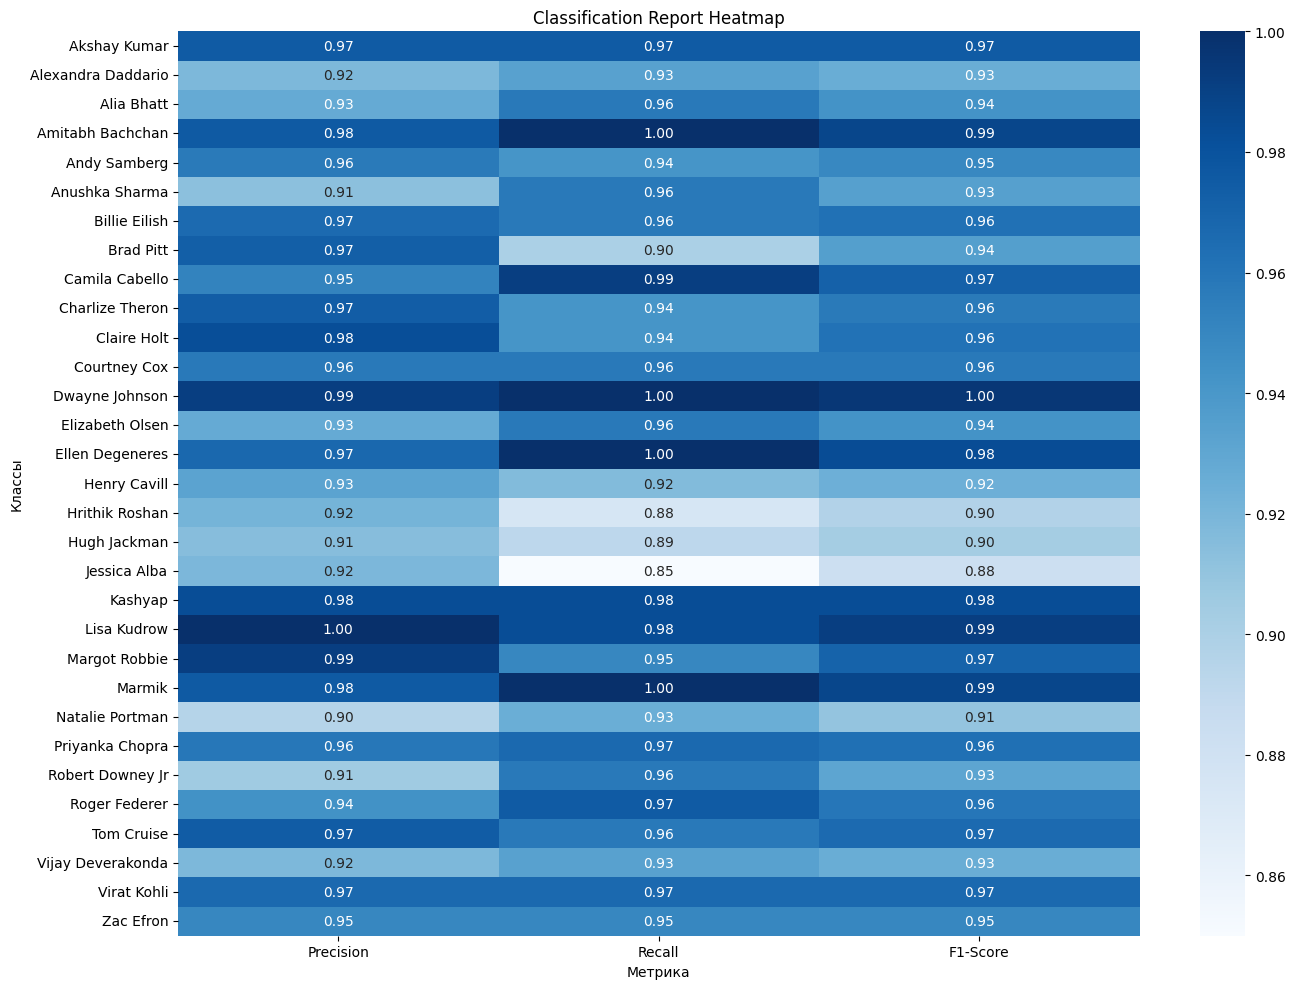

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import seaborn as sns
# Получаем метрики
precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, zero_division=0)

# Создаём DataFrame
metrics_df = pd.DataFrame({
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}, index=class_names)

# Визуализируем
plt.figure(figsize=(14, 10))
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Classification Report Heatmap")
plt.ylabel("Классы")
plt.xlabel("Метрика")
plt.tight_layout()
plt.show()


In [ ]:
# Предсказания
y_pred_probs = model.predict(X_test)  # вероятности
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # метки классов
y_true_classes = np.argmax(y_test, axis=1)  # реальные метки

In [108]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

acc = accuracy_score(y_true_classes, y_pred_classes)
prec, rec, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9516
Precision: 0.9519
Recall:    0.9516
F1 Score:  0.9515


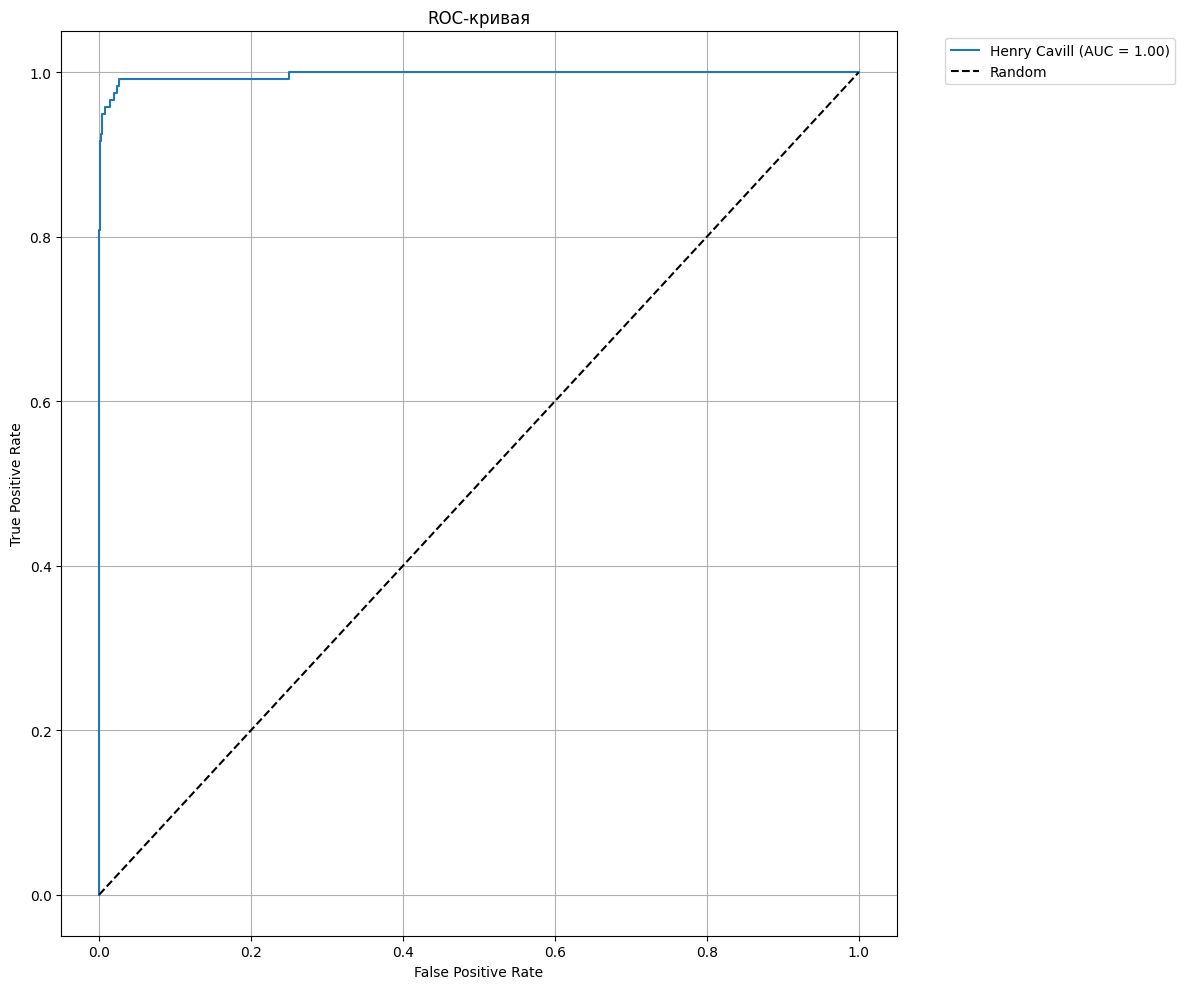

In [106]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
# Binarize для ROC (если y_test ещё не one-hot)
y_test_bin = label_binarize(y_true_classes, classes=range(len(class_names)))

plt.figure(figsize=(12, 10))
# for i in range(len(class_names)):
i = 15
fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()


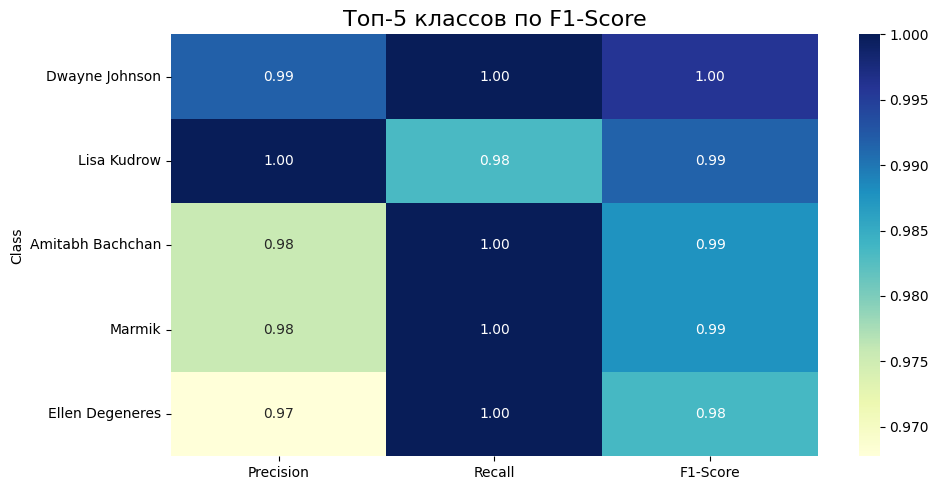

In [87]:
# Вычисляем метрики
precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, zero_division=0)

# Собираем в DataFrame
metrics_df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}).sort_values("F1-Score", ascending=False).reset_index(drop=True)

# Топ-5
top5_df = metrics_df.head(5).set_index("Class")

# Визуализация
plt.figure(figsize=(10, 5))
sns.heatmap(top5_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Топ-5 классов по F1-Score", fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_22152\2926311350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_df, y="Class", x="F1-Score", palette="viridis")


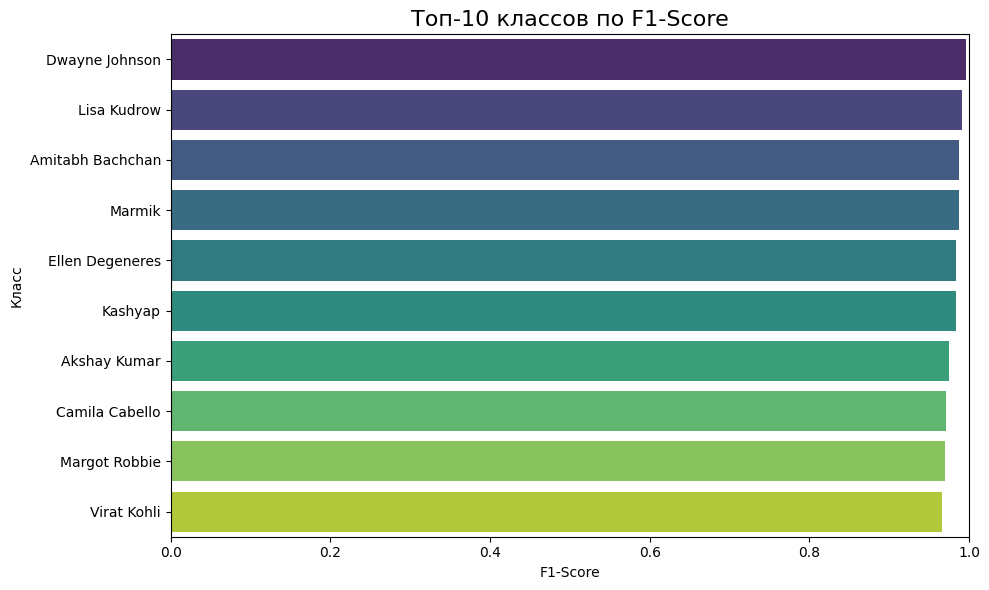

In [85]:
# Топ-10 F1
top10_df = metrics_df.sort_values("F1-Score", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top10_df, y="Class", x="F1-Score", palette="viridis")
plt.title("Топ-10 классов по F1-Score", fontsize=16)
plt.xlabel("F1-Score")
plt.ylabel("Класс")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


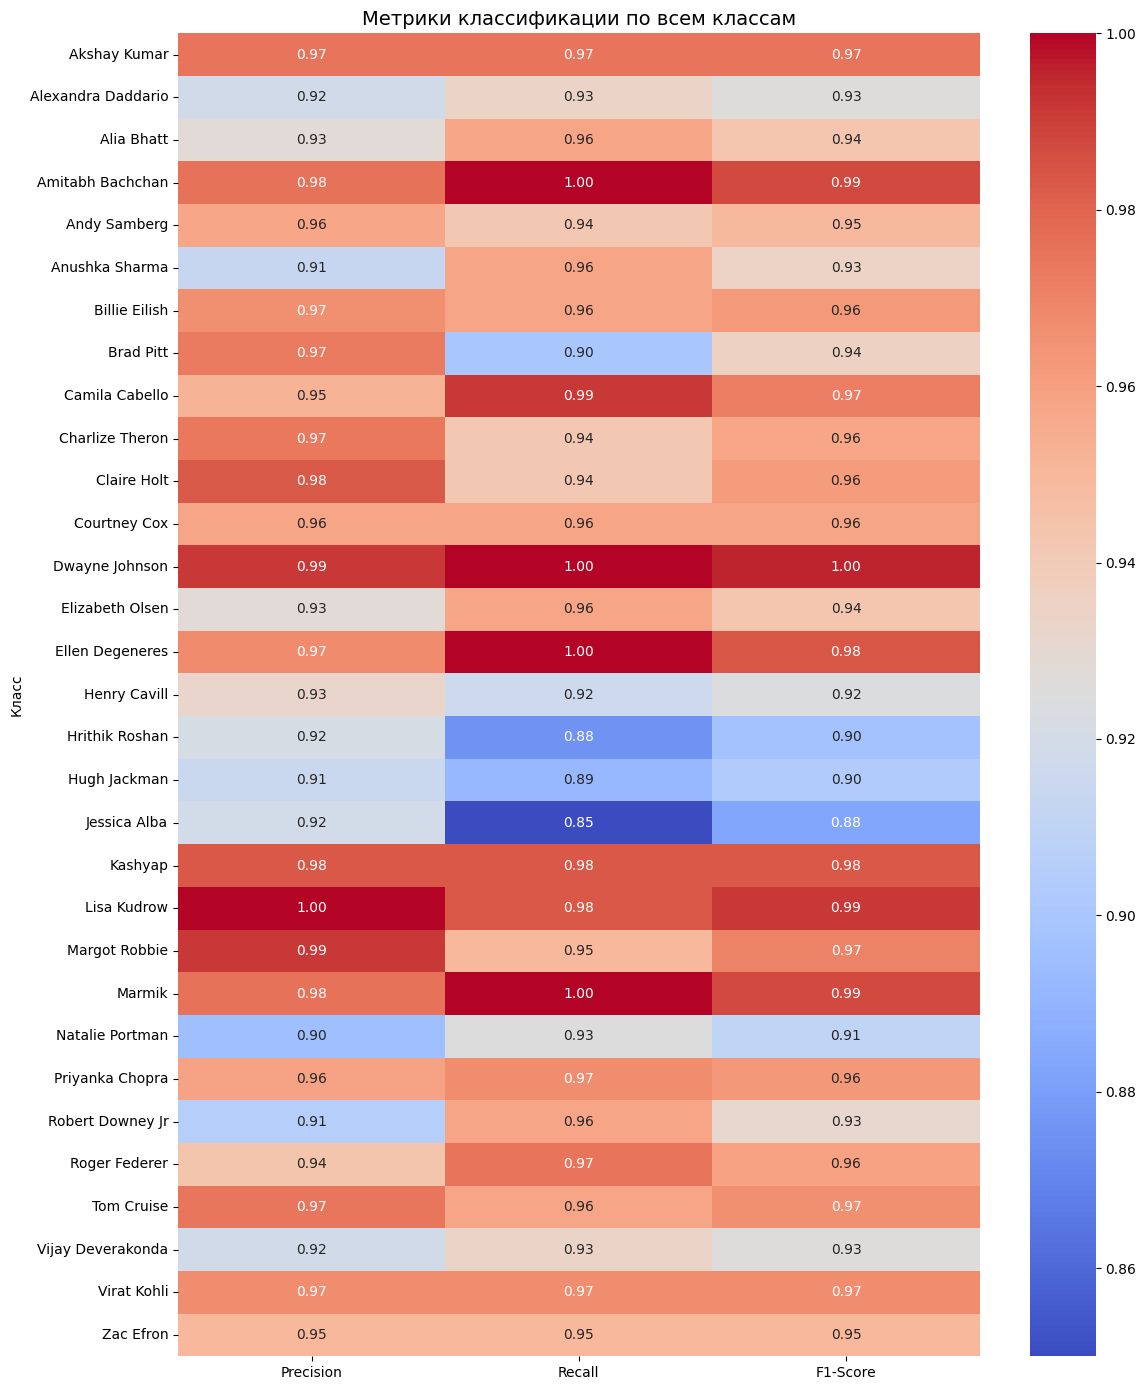

In [88]:
full_df = pd.DataFrame({
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}, index=class_names)

plt.figure(figsize=(12, 14))
sns.heatmap(full_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Метрики классификации по всем классам", fontsize=14)
plt.ylabel("Класс")
plt.tight_layout()
plt.show()


In [89]:
from sklearn.metrics import confusion_matrix

# Создаём confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

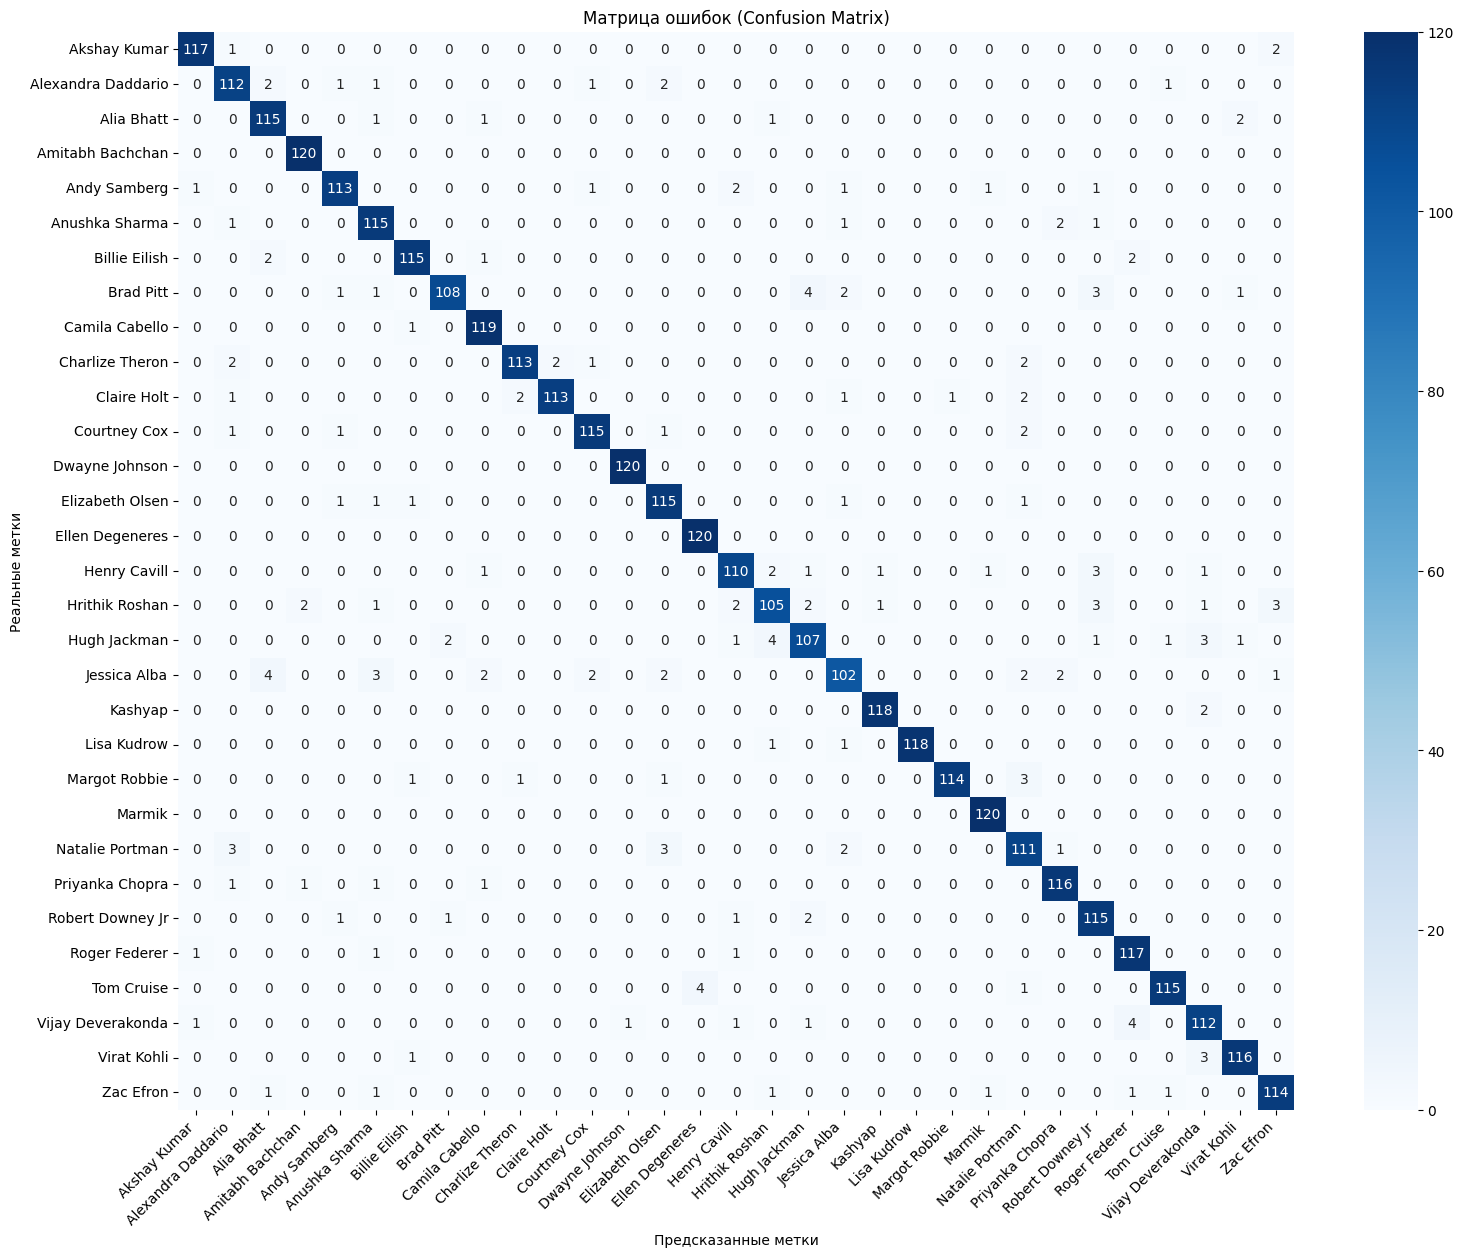

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанные метки')
plt.ylabel('Реальные метки')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xticks(rotation=45, ha='right')  # Поворот подписей на оси X, чтобы они не накладывались
plt.yticks(rotation=0)  # Оставляем ось Y без поворота
plt.show()
